In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
#inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [10]:
#what is ther earliest date?
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [11]:
#how many dates do I have
session.query(func.count(Measurement.date)).all()

[(19550)]

In [12]:
#what is ther latest date?
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [13]:
# Calculate the date 1 year ago from the last data point in the database
#delta time, in this case 365 days ago from today reducing the timedelta for the next query
latest=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago=(dt.datetime.strptime(latest[0], '%Y-%m-%d')-dt.timedelta(days=365)).date()
year_ago

datetime.date(2016, 8, 23)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
sel = [Measurement.date, 
       Measurement.prcp]
yr_data = session.query(*sel).\
    filter(func.strftime(Measurement.date >= year_ago)).\
    order_by(Measurement.date).all()

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data - DRAFT
# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(yr_data, columns=['date', 'prcp'])

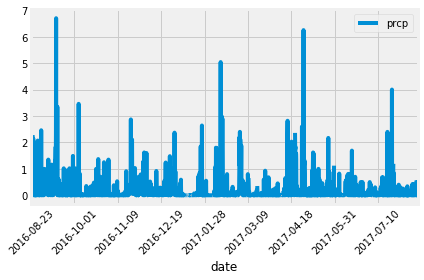

In [16]:
df=pd.DataFrame(yr_data, columns=['date', 'prcp'])
df.set_index('date', inplace=True)
df.plot(x_compat=True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset? -OK
session = Session(engine)
active = session.query(Measurement).group_by('station').count()
print(active)

9


In [19]:
#Print specific weather stations - OK
for row in session.query(Station.station, Station.name).all():
    print(row)

('USC00519397', 'WAIKIKI 717.2, HI US')
('USC00513117', 'KANEOHE 838.1, HI US')
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US')
('USC00517948', 'PEARL CITY, HI US')
('USC00518838', 'UPPER WAHIAWA 874.3, HI US')
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US')
('USC00519281', 'WAIHEE 837.5, HI US')
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US')
('USC00516128', 'MANOA LYON ARBO 785.2, HI US')


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)? - OK
# List the stations and the counts in descending order.
most_active=session.query(Measurement.station,func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [152]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station? #check if quering for specific station is OK, or if needs to be "automated"
low_temp=session.query(Measurement.station,func.min(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()
print(f'Low temperatures per station')
low_temp ## SORTING NOT WORKING

Low temperatures per station


[('USC00519281', 54.0),
 ('USC00519397', 56.0),
 ('USC00513117', 59.0),
 ('USC00519523', 56.0),
 ('USC00516128', 58.0),
 ('USC00514830', 58.0),
 ('USC00511918', 53.0),
 ('USC00517948', 58.0),
 ('USC00518838', 58.0)]

In [151]:
high_temp=session.query(Measurement.station,func.max(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()
print(f'High temperatures per station')
high_temp ## SORTING NOT WORKING

High temperatures per station


[('USC00519281', 85.0),
 ('USC00519397', 87.0),
 ('USC00513117', 85.0),
 ('USC00519523', 85.0),
 ('USC00516128', 84.0),
 ('USC00514830', 85.0),
 ('USC00511918', 87.0),
 ('USC00517948', 87.0),
 ('USC00518838', 83.0)]

In [150]:
avg_temp=session.query(Measurement.station,func.avg(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()
print(f'Average temperatures per station')
avg_temp## SORTING NOT WORKING

Average temperatures per station


[('USC00519281', 71.66378066378067),
 ('USC00519397', 74.55323054331865),
 ('USC00513117', 72.68918420081211),
 ('USC00519523', 74.5436493068565),
 ('USC00516128', 70.91500765696784),
 ('USC00514830', 74.8732970027248),
 ('USC00511918', 71.61596766043456),
 ('USC00517948', 74.68440233236151),
 ('USC00518838', 72.72407045009784)]

In [141]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Design a query to retrieve the last 12 months of precipitation data
sel = [Measurement.tobs]
yr_data2 = session.query(*sel).\
    filter(Measurement.station=='USC00519281').\
    filter(func.strftime(Measurement.date >= year_ago)).all()
#yr_data2

In [142]:
from sqlalchemy import distinct
#Temperatures for x label
yr_data3 = session.query(*sel).\
    filter(Measurement.station=='USC00519281').\
    filter(func.strftime(Measurement.date >= year_ago)).\
    group_by(Measurement.tobs).all()
yr_data3=np.ravel(yr_data3).astype(int)
#yr_data3

In [143]:
#Temperatures frequency
yr_data4 = session.query(func.count(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').\
    filter(func.strftime(Measurement.date >= year_ago)).\
    group_by(Measurement.tobs).all()
yr_data4=np.ravel(yr_data4).astype(int)
#yr_data4

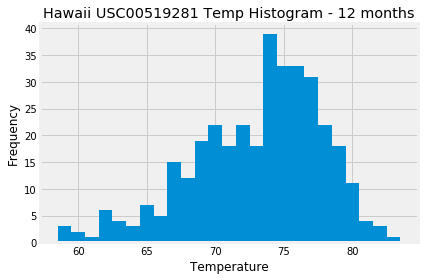

In [153]:
# and plot the results
fig, ax = plt.subplots()
# the histogram of the data
#ax.hist(yr_data3, yr_data4, density=1)
ax.bar(yr_data3, yr_data4, width=1, align='center')
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
ax.set_title('Hawaii USC00519281 Temp Histogram - 12 months')
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d       
    Returns:
        TMIN, TAVE, and TMAX
    """   
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# function usage example
#print(calc_temps('2012-02-28', '2012-03-05'))

In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(f'Min, avg and max temperature according to history for dates between 2017-08-01 and 2017-08-08 wll be:')
tripinit='2017-08-01'
tripend='2017-08-08'
print(calc_temps(tripinit,tripend))
f= np.ravel(calc_temps('2017-08-01', '2017-08-08'))
#f=np.array([f[1])
g=np.array([f[0],f[2]])
#g =float(f[0])
#h= float(f[2])
g
f

Min, avg and max temperature according to history for dates between 2017-08-01 and 2017-08-08 wll be:
[(72.0, 79.15625, 83.0)]


array([72.     , 79.15625, 83.     ])

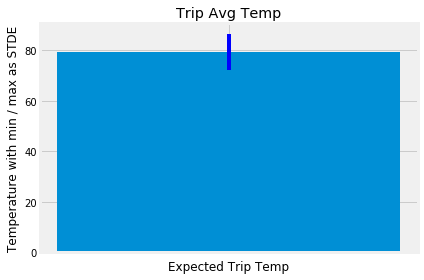

In [137]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
# the histogram of the data
#ax.hist(yr_data3, yr_data4, density=1)
lower_error = f[0]-f[1]
upper_error = f[2]-f[1]
asymmetric_error = [(lower_error, upper_error)]
ax.bar(1, f[1], width=0.8,yerr=asymmetric_error, tick_label="", ecolor="blue")
ax.set_xlabel('Expected Trip Temp')
ax.set_ylabel('Temperature with min / max as STDE')
ax.set_title('Trip Avg Temp')
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()
#asymmetric_error

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
from sqlalchemy import and_, or_, not_
sel = [Measurement.station, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation]
yr_data6 = session.query(*sel).\
    filter(and_(func.strftime(Measurement.date >= tripinit)), (func.strftime(Measurement.date <=tripend))).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(Measurement.prcp.desc()).all() ##why is this not sorting in desc() as instructed??
yr_data6

[('USC00514830', 0.32, 21.5213, -157.8374, 7.0),
 ('USC00519397', 0.04, 21.2716, -157.8168, 3.0),
 ('USC00519281', 0.06, 21.45167, -157.84888999999998, 32.9),
 ('USC00519523', 0.0, 21.33556, -157.71139, 19.5),
 ('USC00516128', 0.7, 21.3331, -157.8025, 152.4)]

## Optional Challenge Assignment

In [94]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    """Daily Normals.    
    Args:
        date (str): A date string in the format '%m-%d'       
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax    
    """    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()   
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [106]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
from datetime import datetime
# Set the start and end date of the trip; already defined in tripinit and tripend
# Use the start and end date to create a range of dates
dates=pd.date_range(
    start=tripinit,
    end=tripend,
    periods=None,
    freq=None,
    tz=None,
    normalize=False,
    name=None,
    closed=None)

In [110]:
dates_list=[]
mins_list=[]
avg_list=[]
maxs_list=[]
for datei in dates:
    #dt.date.today().strftime("%d")
    # Stip off the year and save a list of %m-%d strings
    k=datetime.strftime(datei,"%m-%d")
    dates_list.append(k)
    # Loop through the list of %m-%d strings and calculate the normals for each date
    h=daily_normals(k)
    mins_list.append(h[0][0])
    avg_list.append(h[0][1])
    maxs_list.append(h[0][2])

In [122]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
## k=datetime.strptime(tripinit, '%Y-%m-%d') #Why this works and dt.xxx not??? CHECK THIS OUT WITH DOESN'T WORK WITH A TA
## date_object = datetime.strftime(k, '%m-%d') # THIS DO WORKS
## date_object
vacations_temp = pd.DataFrame(
    {'Date': dates_list,
     'Min Temp': mins_list,
     'Avg Temp': avg_list,
     'Max Temp': maxs_list,
    }).set_index('Date')
vacations_temp

,Min Temp,Avg Temp,Max Temp
Date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0
08-08,68.0,76.557692,83.0


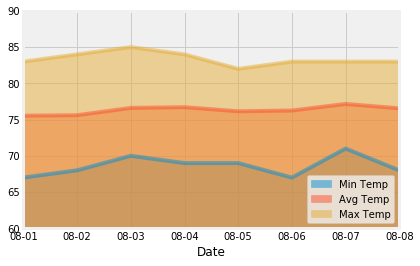

In [158]:
# Plot the daily normals as an area plot with `stacked=False`
ax1 = vacations_temp.plot.area(stacked=False).set_ylim(60,90)

In [ ]:
## END OF HOMEWORK

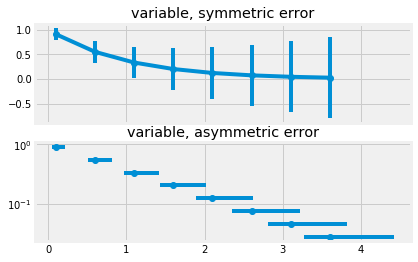

[array([0.048, 0.088, 0.128, 0.168, 0.208, 0.248, 0.288, 0.328]),
 array([0.12, 0.22, 0.32, 0.42, 0.52, 0.62, 0.72, 0.82])]

In [36]:
# Research CODE for error in bar graph, 
#example data
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)

# example error bar values that vary with x-position
error = 0.1 + 0.2 * x

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.errorbar(x, y, yerr=error, fmt='-o')
ax0.set_title('variable, symmetric error')

# error bar values w/ different -/+ errors that
# also vary with the x-position
lower_error = 0.4 * error
upper_error = error
asymmetric_error = [lower_error, upper_error]

ax1.errorbar(x, y, xerr=asymmetric_error, fmt='o')
ax1.set_title('variable, asymmetric error')
ax1.set_yscale('log')
plt.show()
x
asymmetric_error